## Code

In [1]:
from enum import Enum
from blocksnet import LandUse

class ResidentialType(Enum):
    HIGH_RISE = 'МКД'
    MID_RISE = 'Среднеэтажная'
    LOW_RISE = 'ИЖС'

LAND_USE_FSIS = {
    LandUse.RESIDENTIAL: (0.5, 3.0),
    LandUse.BUSINESS: (1.0, 3.0),
    LandUse.RECREATION: (0.05, 0.2),
    LandUse.SPECIAL: (0.05, 0.2),
    LandUse.INDUSTRIAL: (0.3, 1.5),
    LandUse.AGRICULTURE: (0.1, 0.2),
    LandUse.TRANSPORT: (0.2, 1.0),
}

LAND_USE_GSIS = {
    LandUse.RESIDENTIAL: (0.2, 0.8),
    LandUse.BUSINESS: (0.0, 0.8),
    LandUse.RECREATION: (0.0, 0.3),
    LandUse.SPECIAL: (0.05, 0.15),
    LandUse.INDUSTRIAL: (0.2, 0.8),
    LandUse.AGRICULTURE: (0.0, 0.6),
    LandUse.TRANSPORT: (0.0, 0.8),
}

/home/vasilstar/optimizer-api/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
import shapely
import pandas as pd
from pydantic import BaseModel, Field, InstanceOf

METERS_IN_HECTARE = 10_000

class Block(BaseModel):
    geometry : InstanceOf[shapely.Polygon]
    land_use : LandUse | None
    residential_type : ResidentialType | None

    @property
    def area_m2(self):
        return self.geometry.area
    
    @property
    def area_ha(self):
        return self.area_m2 / METERS_IN_HECTARE
    
    @property
    def fsi(self):
        land_use = self.land_use
        residential_type = self.residential_type
        if land_use == LandUse.RESIDENTIAL:
            if residential_type == ResidentialType.HIGH_RISE:
                return 0.7
            if residential_type == ResidentialType.MID_RISE:
                return 0.35
            if residential_type == ResidentialType.LOW_RISE:
                return 0.2
        if LandUse is None:
            return sum(v[0] for v in LAND_USE_FSIS.values()) / len(LAND_USE_FSIS)
        return LAND_USE_FSIS[land_use][0]
    
    @property
    def gsi(self):
        land_use = self.land_use
        if LandUse is None:
            return sum(v[0] for v in LAND_USE_GSIS.values()) / len(LAND_USE_GSIS)
        return LAND_USE_GSIS[land_use][0]
    
    @property
    def footprint_area(self):
        return self.area_m2 * self.gsi

    @property
    def build_floor_area(self):
        return self.area_m2 * self.fsi
    
    @property
    def residential_area(self):
        if self.land_use == LandUse.RESIDENTIAL:
            return self.build_floor_area * 0.7
        return 0
    
    @property
    def non_residential_area(self):
        if self.land_use == LandUse.RESIDENTIAL:
            return self.build_floor_area * 0.3
        return self.build_floor_area

In [28]:
TERRITORY_AREA_HA_KEY = 'Площадь рассматриваемой территории (га)'
TERRITORY_AREA_M2_KEY = 'Площадь рассматриваемой территории (м2)'

GSI_KEY = 'Индекс застройки (м2 / м2)'
FP_AREA_KEY = 'Площадь пятна застройки (м2)'

FSI_KEY = 'Коэффициент этажности (м2 / м2)'
BFA_KEY = "Поэтажная площадь зданий (м2)"
BFA_RESIDENTIAL_KEY = "Поэтажная площадь жилых зданий (м2)"
BFA_NON_RESIDENTIAL_KEY = "Поэтажная площадь нежилых зданий (м2)"

POPULATION_KEY = 'Численность населения (чел)'
APARTMENTS_KEY = 'Максимальное количество квартир'
WORKING_POPULATION_KEY = 'Численность работающего населения (чел)'

POPULATION_DENSITY_M2_KEY = 'Плотность населения (чел / м2)'
POPULATION_DENSITY_HA_KEY = 'Плотность населения (чел / га)'

PROVISION_KINDERGARTEN_KEY = 'Дошкольные образовательные учреждения (мест)' #61
PROVISION_SCHOOL_KEY = 'Общеобразовательные учреждения (мест)' #120
PROVISION_POLYCLINIC_KEY = 'Амбулаторно-поликлинические учреждения (посещений)' #13
PROVISION_CULTURE_KEY = 'Культурные учреждения (м2)' # 165
PROVISION_SPORT_KEY = 'Спортивные учреждения (м2)' # 350
PROVISION_COMMERCE_KEY = 'Торговые учреждения (м2)' # 300


class BlocksContainer(BaseModel):
    blocks : list[Block]

    @property
    def area_ha(self):
        return sum(b.area_ha for b in self.blocks)
    
    @property
    def area_m2(self):
        return sum(b.area_m2 for b in self.blocks)
    
    @property
    def gsi(self):
        return self.footprint_area / self.area_m2
    
    @property
    def footprint_area(self):
        return sum(b.footprint_area for b in self.blocks)
    
    @property
    def fsi(self):
        return self.build_floor_area / self.area_m2
    
    @property
    def build_floor_area(self):
        return sum(b.build_floor_area for b in self.blocks)
    
    @property
    def residential_area(self):
        return sum(b.residential_area for b in self.blocks)
    
    @property
    def non_residential_area(self):
        return sum(b.non_residential_area for b in self.blocks)
    
    @property
    def population(self):
        return self.residential_area / 50
    
    @property
    def apartments(self):
        return self.population / 2.1
    
    @property
    def working_population(self):
        return self.population * 0.7
    
    @property
    def population_density_m2(self):
        return self.population / self.area_m2
    
    @property
    def population_density_ha(self):
        return self.population / self.area_ha
    
    @property
    def provision_kindergarten(self):
        return self.population / 1000 * 61

    @property
    def provision_school(self):
        return self.population / 1000 * 120
    
    @property
    def provision_polyclinic(self):
        return self.population / 1000 * 13
    
    @property
    def provision_culture(self):
        return self.population / 1000 * 165
    
    @property
    def provision_sport(self):
        return self.population / 1000 * 350
    
    @property
    def provision_commerce(self):
        return self.population / 1000 * 300

    def get_indicators(self):
        return {
            TERRITORY_AREA_HA_KEY : round(self.area_ha,2),
            TERRITORY_AREA_M2_KEY : round(self.area_m2),
            GSI_KEY : round(self.gsi,1),
            FP_AREA_KEY : round(self.footprint_area),
            FSI_KEY : round(self.fsi, 1),
            BFA_KEY : round(self.build_floor_area),
            BFA_RESIDENTIAL_KEY : round(self.residential_area),
            BFA_NON_RESIDENTIAL_KEY : round(self.non_residential_area),
            POPULATION_KEY : round(self.population),
            APARTMENTS_KEY : round(self.apartments),
            WORKING_POPULATION_KEY : round(self.working_population),
            POPULATION_DENSITY_M2_KEY : round(self.population_density_m2, 2),
            POPULATION_DENSITY_HA_KEY : round(self.population_density_ha, 2),
            PROVISION_KINDERGARTEN_KEY : round(self.provision_kindergarten),
            PROVISION_SCHOOL_KEY : round(self.provision_school),
            PROVISION_POLYCLINIC_KEY : round(self.provision_polyclinic),
            PROVISION_CULTURE_KEY : round(self.provision_culture),
            PROVISION_SPORT_KEY : round(self.provision_sport),
            PROVISION_COMMERCE_KEY : round(self.provision_commerce),
        }

In [30]:
import geopandas as gpd

def get_indicators(gdf : gpd.GeoDataFrame, land_use_column : str, residential_type : ResidentialType | None):
    gdf = gdf[['geometry', land_use_column]].rename(columns={land_use_column : 'land_use'})
    blocks = [Block(**row, residential_type = residential_type) for _,row in gdf.iterrows()]
    blocks_container = BlocksContainer(blocks=blocks)
    return blocks_container.get_indicators()

## Example

In [31]:
import geopandas as gpd

land_use_gdf = gpd.read_file('response.json')
crs = land_use_gdf.estimate_utm_crs()
land_use_gdf = land_use_gdf.to_crs(crs)

### Before

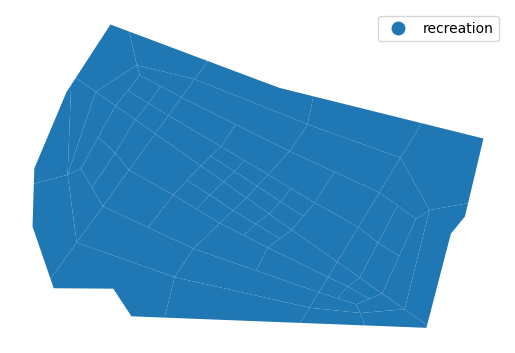

In [32]:
land_use_gdf.plot(column='land_use', legend=True).set_axis_off()

In [33]:
get_indicators(land_use_gdf, 'land_use', None)

{'Площадь рассматриваемой территории (га)': 578.96,
 'Площадь рассматриваемой территории (м2)': 5789556,
 'Индекс застройки (м2 / м2)': 0.0,
 'Площадь пятна застройки (м2)': 0,
 'Коэффициент этажности (м2 / м2)': 0.0,
 'Поэтажная площадь зданий (м2)': 289478,
 'Поэтажная площадь жилых зданий (м2)': 0,
 'Поэтажная площадь нежилых зданий (м2)': 289478,
 'Численность населения (чел)': 0,
 'Максимальное количество квартир': 0,
 'Численность работающего населения (чел)': 0,
 'Плотность населения (чел / м2)': 0.0,
 'Плотность населения (чел / га)': 0.0,
 'Дошкольные образовательные учреждения (мест)': 0,
 'Общеобразовательные учреждения (мест)': 0,
 'Амбулаторно-поликлинические учреждения (посещений)': 0,
 'Культурные учреждения (м2)': 0,
 'Спортивные учреждения (м2)': 0,
 'Торговые учреждения (м2)': 0}

### After

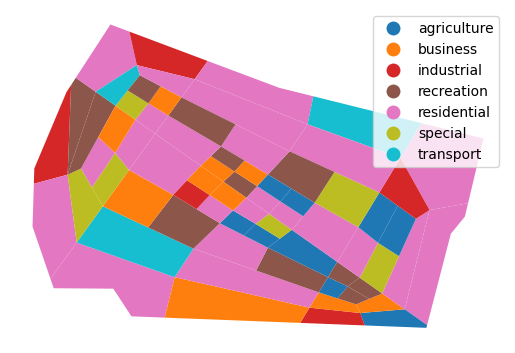

In [34]:
land_use_gdf.plot(column='assigned_land_use', legend=True).set_axis_off()


In [35]:
get_indicators(land_use_gdf, 'assigned_land_use', ResidentialType.HIGH_RISE)

{'Площадь рассматриваемой территории (га)': 578.96,
 'Площадь рассматриваемой территории (м2)': 5789556,
 'Индекс застройки (м2 / м2)': 0.1,
 'Площадь пятна застройки (м2)': 667998,
 'Коэффициент этажности (м2 / м2)': 0.5,
 'Поэтажная площадь зданий (м2)': 2931072,
 'Поэтажная площадь жилых зданий (м2)': 1404980,
 'Поэтажная площадь нежилых зданий (м2)': 1526093,
 'Численность населения (чел)': 28100,
 'Максимальное количество квартир': 13381,
 'Численность работающего населения (чел)': 19670,
 'Плотность населения (чел / м2)': 0.0,
 'Плотность населения (чел / га)': 48.53,
 'Дошкольные образовательные учреждения (мест)': 1714,
 'Общеобразовательные учреждения (мест)': 3372,
 'Амбулаторно-поликлинические учреждения (посещений)': 365,
 'Культурные учреждения (м2)': 4636,
 'Спортивные учреждения (м2)': 9835,
 'Торговые учреждения (м2)': 8430}